# Data processing

In [1]:
import sys
sys.path.append('/home/alina/repos/Audio-Classification-HF/')
import os
import librosa
import torch
import numpy as np

from datasets import DatasetDict, load_dataset 
from transformers import (
    HubertConfig,
    Wav2Vec2FeatureExtractor,
    set_seed
)

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
set_seed(42)
PROJECT_ROOT = "/home/alina/repos/Audio-Classification-HF"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
dataset_config = {
  "LOADING_SCRIPT_FILES": os.path.join(PROJECT_ROOT, "src/data/emocall.py"),
  "CONFIG_NAME": "clean",
  "DATA_DIR": os.path.join(PROJECT_ROOT, "data/emocall.zip"),
  "CACHE_DIR": os.path.join(PROJECT_ROOT, "data/cache_emocall"),
}
# print(dataset_config["LOADING_SCRIPT_FILES"], dataset_config["CONFIG_NAME"], dataset_config["DATA_DIR"], dataset_config["CACHE_DIR"])
ds = load_dataset(
  dataset_config["LOADING_SCRIPT_FILES"],
  dataset_config["CONFIG_NAME"],
  data_dir=dataset_config["DATA_DIR"],
  cache_dir=dataset_config["CACHE_DIR"]
)
print(ds)

DatasetDict({
    train: Dataset({
        features: ['file', 'label'],
        num_rows: 329
    })
})


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/datasets/load.py:926: FutureWarning: The repository for emocall contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /home/alina/repos/Audio-Classification-HF/src/data/emocall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
train_test = ds['train'].train_test_split(test_size=0.4, seed=42)

ds = DatasetDict(
    {
        "train": train_test["train"],
        "test": train_test["test"],
    }
)
ds

DatasetDict({
    train: Dataset({
        features: ['file', 'label'],
        num_rows: 197
    })
    test: Dataset({
        features: ['file', 'label'],
        num_rows: 132
    })
})

other 28
positive 39
sad 45
angry 43
neutral 42


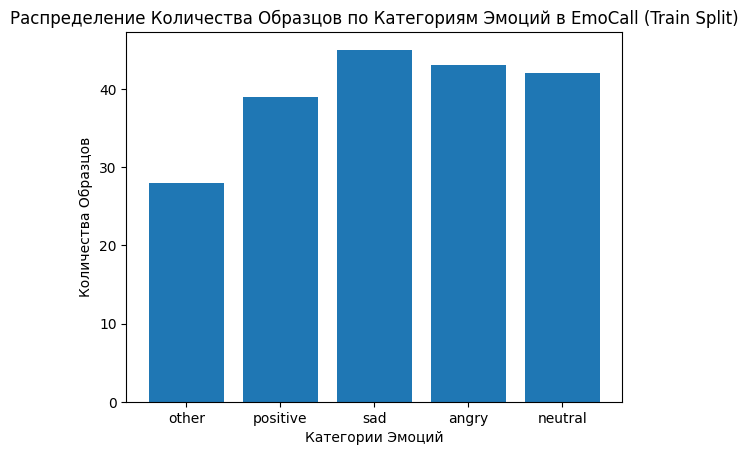

In [5]:
import matplotlib.pyplot as plt 
emo_count = {}
for emo in set(ds['train']['label']):
    print(f"{emo} {ds['train']['label'].count(emo)}")
    emo_count.update({emo: ds['train']['label'].count(emo)})

plt.bar(emo_count.keys(), emo_count.values())
plt.xlabel('Категории Эмоций')
plt.ylabel('Количества Образцов')
plt.title('Распределение Количества Образцов по Категориям Эмоций в EmoCall (Train Split)')
plt.show()

In [6]:
for emo in set(ds['train']['label']):
    print(f"{emo} {ds['train']['label'].count(emo)}")

other 28
positive 39
sad 45
angry 43
neutral 42


In [7]:
for emo in set(ds['test']['label']):
    print(f"{emo} {ds['test']['label'].count(emo)}")

other 21
positive 31
sad 25
neutral 28
angry 27


In [8]:
INPUT_FIELD = "input_values"
LABEL_FIELD = "labels"

def prepare_dataset(batch, feature_extractor):
    audio_arr = batch["array"]
    # print(audio_arr)
    
    input = feature_extractor(
        audio_arr, sampling_rate=16000, padding=True, return_tensors="pt"
    )

    batch[INPUT_FIELD] = input.input_values
    batch[LABEL_FIELD] = batch[
        "label"
    ]  # colname MUST be labels as Trainer will look for it by default

    return batch


In [9]:
ds = ds.class_encode_column("label")

#### Choose feature extractor depending on a model you are using

In [10]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-large") 
feature_extractor

Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": true,
  "sampling_rate": 16000
}

In [11]:
ds = ds.map(
        lambda x: {
            "array": librosa.load(x["file"], sr=16000, mono=True)[0]
        },
        num_proc=2,
    )
ds

DatasetDict({
    train: Dataset({
        features: ['file', 'label', 'array'],
        num_rows: 197
    })
    test: Dataset({
        features: ['file', 'label', 'array'],
        num_rows: 132
    })
})

In [12]:
encoded_dataset = ds.map(prepare_dataset, 
                         fn_kwargs={"feature_extractor": feature_extractor}, 
                         batched=True, 
                         batch_size=4)

# HUBERT


## Validation

In [10]:
import sys
sys.path.append('/home/alina/repos/Audio-Classification-HF/')
import os
import logging
import librosa
import torch

import wandb
import numpy as np

from datasets import DatasetDict, load_dataset, load_metric
from transformers import (
    HubertForSequenceClassification,
)
from src.utils import collator

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [11]:
model_path = "./results/emocall/hubert/05 _exp/checkpoint-32"


config = HubertConfig.from_pretrained(model_path)

model = HubertForSequenceClassification.from_pretrained(
    model_path,
    config=config,
).to(device)

In [12]:
from tqdm import tqdm

model.eval()
preds = []
for sample in tqdm(encoded_dataset['test']):
    logits = model(torch.cuda.FloatTensor(sample['input_values']).unsqueeze(dim=0)).logits
    # print(logits)
    predictions = torch.argmax(logits, dim=-1)
    # print(predictions)  
    predicted_emotion = config.id2label[predictions.cpu().data.numpy()[0]]
    preds.append(predicted_emotion)
    # print(predicted_emotion)

  0%|          | 0/132 [00:00<?, ?it/s]/tmp/ipykernel_634037/3130536748.py:6: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/torch/csrc/tensor/python_tensor.cpp:83.)
  logits = model(torch.cuda.FloatTensor(sample['input_values']).unsqueeze(dim=0)).logits
100%|██████████| 132/132 [00:35<00:00,  3.77it/s]


In [13]:
gts  = [config.id2label[gt] for gt in encoded_dataset['test']['labels']]

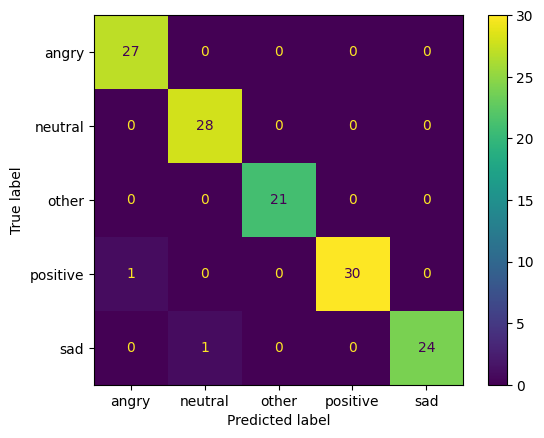

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(gts, preds, labels=list(config.label2id.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(config.label2id.keys()))
disp.plot()

plt.show()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(gts, preds, target_names=list(config.label2id.keys())))

              precision    recall  f1-score   support

       angry       0.96      1.00      0.98        27
     neutral       0.97      1.00      0.98        28
       other       1.00      1.00      1.00        21
    positive       1.00      0.97      0.98        31
         sad       1.00      0.96      0.98        25

    accuracy                           0.98       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.98      0.98       132



## Training

In [21]:
import sys
sys.path.append('/home/alina/repos/Audio-Classification-HF/')
import os
import logging
import librosa
import torch

import wandb
import numpy as np

from datasets import DatasetDict, load_dataset, load_metric
from transformers import (
    TrainingArguments,
    HubertForSequenceClassification,
    Trainer
)
from src.utils import collator

In [18]:
model_path = "./results/hubert/05_exp_dusha/checkpoint-6500"

config = HubertConfig.from_pretrained(model_path)

model = HubertForSequenceClassification.from_pretrained(
    model_path,
    config=config, 
).to(device)

In [19]:
model.config.label2id

{'angry': '0', 'neutral': '1', 'other': '2', 'positive': '3', 'sad': '4'}

In [22]:
encoded_dataset["train"].features["label"].names

['angry', 'neutral', 'other', 'positive', 'sad']

In [23]:
model.freeze_feature_extractor()

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/models/hubert/modeling_hubert.py:1299: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [24]:
training_args = TrainingArguments(
    output_dir="./results/emocall/hubert/05 _exp",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    evaluation_strategy="steps",
    num_train_epochs=2.0,
    fp16=True,
    save_steps=4,
    eval_steps=4,
    logging_steps=4,
    learning_rate=1e-4,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="wandb"
)

In [ ]:
USER = "USERNAME"
WANDB_PROJECT = "PROJECTNAME"
wandb.init(entity=USER, project=WANDB_PROJECT)

In [26]:
metric = load_metric("accuracy", trust_remote_code=True)
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

/tmp/ipykernel_627641/1768617425.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


In [27]:
data_collator = collator.DataCollatorCTCWithPadding(
    processor=feature_extractor, padding=True
)

In [28]:
trainer = Trainer(
    model=model,  # the instantiated 🤗 Transformers model to be trained
    args=training_args,  # training arguments, defined above
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [29]:
trainer.train()

trainer.save_model(os.path.join(PROJECT_ROOT, "./results/emocall/hubert/05 _exp"))

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
4,2.238300,2.191989,0.651515
8,1.660300,2.271421,0.500000
12,1.039400,1.752690,0.522727
16,1.523800,0.252032,0.916667
20,0.306000,0.398200,0.848485
24,0.544000,0.164226,0.924242
28,0.536100,0.097903,0.969697
32,0.231600,0.073109,0.992424
36,0.178400,0.124047,0.954545
40,0.164000,0.113485,0.969697


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/pyt

# Wav2Vec2.0

## Training

In [30]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput
from transformers import Trainer
from datasets import load_metric
import wandb
@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [11]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [17]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [18]:
data_collator = DataCollatorCTCWithPadding(processor=feature_extractor, padding=True)
is_regression = False

In [19]:
metric = load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

/tmp/ipykernel_635344/2206704982.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


In [20]:
model_name_or_path = "./models/wav2vec_02_exp/audio-model"

model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
)

In [21]:
model.freeze_feature_extractor()

In [ ]:
USER = "USERNAME"
WANDB_PROJECT = "PROJECTNAME"
wandb.init(entity=USER, project=WANDB_PROJECT)

In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results/emocall/wav2vec/02 _exp",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    evaluation_strategy="steps",
    num_train_epochs=2.0,
    fp16=True,
    save_steps=4,
    eval_steps=4,
    logging_steps=4,
    learning_rate=1e-4,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="wandb"
)


In [31]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    tokenizer=feature_extractor,
)

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [32]:
trainer.train()

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
4,1.097500,0.384592,0.848485
8,0.304400,0.201935,0.924242
12,0.330300,0.189874,0.946970
16,0.239200,0.114168,0.984848
20,0.429400,0.125232,0.977273
24,0.058000,0.096005,0.977273
28,0.113700,0.060541,0.969697
32,0.267600,0.073213,0.969697
36,0.049400,0.086595,0.977273
40,0.083900,0.051040,0.992424


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/pyt

TrainOutput(global_step=98, training_loss=0.15716058137465497, metrics={'train_runtime': 782.6547, 'train_samples_per_second': 0.503, 'train_steps_per_second': 0.125, 'total_flos': 1.8626494018737597e+17, 'train_loss': 0.15716058137465497, 'epoch': 1.99})

## Validation

In [11]:
import sys
sys.path.append('/home/alina/repos/Audio-Classification-HF/')

import os
import logging
import librosa
import torch

import wandb
import numpy as np

from datasets import DatasetDict, load_dataset, load_metric, concatenate_datasets
from transformers import (
    HubertForSequenceClassification,
    AutoModelForAudioClassification,
    HubertConfig,
    Wav2Vec2Processor,
    AutoConfig,
    Trainer,
    TrainingArguments,
    Wav2Vec2FeatureExtractor,
    set_seed
)
from src.utils import collator

from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [12]:
@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [13]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)

In [14]:
class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
    
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """
    
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [15]:
data_collator = DataCollatorCTCWithPadding(processor=feature_extractor, padding=True)

is_regression = False

In [16]:
metric = load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

/tmp/ipykernel_636414/2206704982.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


In [17]:
model_name_or_path = "./results/emocall/wav2vec/02 _exp/checkpoint-40"
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path
).to(device)

In [18]:
from tqdm import tqdm

model.eval()
preds = []
for sample in tqdm(encoded_dataset['test']):
    logits = model(torch.cuda.FloatTensor(sample['input_values']).unsqueeze(dim=0)).logits
    predictions = torch.argmax(logits, dim=-1)
    predicted_emotion = model.config.id2label[predictions.cpu().data.numpy()[0]]
    preds.append(predicted_emotion)

  0%|          | 0/132 [00:00<?, ?it/s]/tmp/ipykernel_636414/1612859405.py:6: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/torch/csrc/tensor/python_tensor.cpp:83.)
  logits = model(torch.cuda.FloatTensor(sample['input_values']).unsqueeze(dim=0)).logits
100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


In [19]:
gts  = [model.config.id2label[gt] for gt in encoded_dataset['test']['labels']]

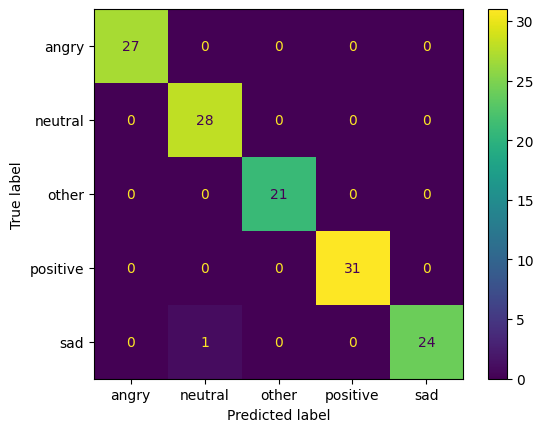

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(gts, preds, labels=list(model.config.label2id.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(model.config.label2id.keys()))
disp.plot()
plt.show()

In [21]:
from sklearn.metrics import classification_report

print(classification_report(gts, preds, target_names=list(model.config.label2id.keys())))

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        27
     neutral       0.97      1.00      0.98        28
       other       1.00      1.00      1.00        21
    positive       1.00      1.00      1.00        31
         sad       1.00      0.96      0.98        25

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132



# WavLM

## Training

In [13]:
import sys
import os
sys.path.append('/home/alina/repos/Audio-Classification-HF/')

import wandb
import numpy as np
from packaging import version

import torch
from torch import nn
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from datasets import DatasetDict, load_dataset, load_metric, concatenate_datasets
from transformers import (
    AutoConfig,
    Trainer,
    TrainingArguments,
    set_seed,
    is_apex_available,
    Wav2Vec2Processor,
    WavLMForSequenceClassification,
    AutoFeatureExtractor,
    AutoModelForAudioClassification
)

from transformers.file_utils import ModelOutput
from src.utils import collator

from dataclasses import dataclass
from typing import Dict, List, Any, Optional, Union, Tuple

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [14]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [15]:
model_name_or_path = "./results/wavlm/05_exp/checkpoint-4000"

model = WavLMForSequenceClassification.from_pretrained(
        model_name_or_path,
        trust_remote_code=True,
    ).to(device)


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [16]:
model.freeze_feature_extractor()

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/models/wavlm/modeling_wavlm.py:1440: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [17]:
metric = load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

/tmp/ipykernel_894250/2206704982.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


In [18]:
data_collator = DataCollatorCTCWithPadding(processor=feature_extractor, padding=True)

In [19]:
training_args = TrainingArguments(
    output_dir="./results/emocall/wavlm/05 _exp",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    evaluation_strategy="steps",
    num_train_epochs=2.0,
    fp16=True,
    save_steps=4,
    eval_steps=4,
    logging_steps=4,
    learning_rate=1e-4,
    gradient_checkpointing=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="wandb"
)

In [20]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    tokenizer=feature_extractor,
)

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
USER = "USERNAME"
WANDB_PROJECT = "PROJECTNAME"
wandb.init(entity=USER, project=WANDB_PROJECT)

In [22]:
trainer.train()
trainer.save_model(os.path.join(PROJECT_ROOT, "/home/alina/repos/Audio-Classification-HF/results/emocall/wavlm/06_exp"))

  0%|          | 0/98 [00:00<?, ?it/s]/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  4%|▍         | 4/98 [00:04<01:34,  1.00s/it]

{'loss': 0.299, 'grad_norm': 0.32410961389541626, 'learning_rate': 9.591836734693878e-05, 'epoch': 0.08}


                                              
  4%|▍         | 4/98 [00:31<01:34,  1.00s/it]   

{'eval_loss': 0.24803511798381805, 'eval_accuracy': 0.9393939393939394, 'eval_runtime': 27.0764, 'eval_samples_per_second': 4.875, 'eval_steps_per_second': 4.875, 'epoch': 0.08}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  8%|▊         | 8/98 [00:36<06:00,  4.01s/it]

{'loss': 0.6996, 'grad_norm': 5.039416790008545, 'learning_rate': 9.183673469387756e-05, 'epoch': 0.16}


                                              
  8%|▊         | 8/98 [01:03<06:00,  4.01s/it]   

{'eval_loss': 0.23549790680408478, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 27.0182, 'eval_samples_per_second': 4.886, 'eval_steps_per_second': 4.886, 'epoch': 0.16}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 12%|█▏        | 12/98 [01:08<06:30,  4.54s/it]

{'loss': 0.0489, 'grad_norm': 0.2104828655719757, 'learning_rate': 8.775510204081632e-05, 'epoch': 0.24}


                                               
 12%|█▏        | 12/98 [01:34<06:30,  4.54s/it]  

{'eval_loss': 0.2235647439956665, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.6156, 'eval_samples_per_second': 4.96, 'eval_steps_per_second': 4.96, 'epoch': 0.24}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 16%|█▋        | 16/98 [01:39<06:19,  4.62s/it]

{'loss': 0.3197, 'grad_norm': 5.309678554534912, 'learning_rate': 8.367346938775511e-05, 'epoch': 0.32}


                                               
 16%|█▋        | 16/98 [02:06<06:19,  4.62s/it]  

{'eval_loss': 0.21508781611919403, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.3823, 'eval_samples_per_second': 5.003, 'eval_steps_per_second': 5.003, 'epoch': 0.32}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 20%|██        | 20/98 [02:11<06:04,  4.68s/it]

{'loss': 0.5259, 'grad_norm': 0.23400628566741943, 'learning_rate': 7.959183673469388e-05, 'epoch': 0.41}


                                               
 20%|██        | 20/98 [02:37<06:04,  4.68s/it]  

{'eval_loss': 0.20622481405735016, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.3611, 'eval_samples_per_second': 5.007, 'eval_steps_per_second': 5.007, 'epoch': 0.41}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 24%|██▍       | 24/98 [02:42<05:41,  4.61s/it]

{'loss': 0.3213, 'grad_norm': 1.8308767080307007, 'learning_rate': 7.551020408163266e-05, 'epoch': 0.49}


                                               
 24%|██▍       | 24/98 [03:09<05:41,  4.61s/it]  

{'eval_loss': 0.19744493067264557, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.5386, 'eval_samples_per_second': 4.974, 'eval_steps_per_second': 4.974, 'epoch': 0.49}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 29%|██▊       | 28/98 [03:14<05:24,  4.63s/it]

{'loss': 0.4067, 'grad_norm': 5.130142688751221, 'learning_rate': 7.142857142857143e-05, 'epoch': 0.57}


                                               
 29%|██▊       | 28/98 [03:40<05:24,  4.63s/it]  

{'eval_loss': 0.1917748749256134, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.5771, 'eval_samples_per_second': 4.967, 'eval_steps_per_second': 4.967, 'epoch': 0.57}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 33%|███▎      | 32/98 [03:46<05:07,  4.66s/it]

{'loss': 0.1798, 'grad_norm': 0.06079740822315216, 'learning_rate': 6.73469387755102e-05, 'epoch': 0.65}


                                               
 33%|███▎      | 32/98 [04:12<05:07,  4.66s/it]  

{'eval_loss': 0.18704871833324432, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.1074, 'eval_samples_per_second': 5.056, 'eval_steps_per_second': 5.056, 'epoch': 0.65}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 37%|███▋      | 36/98 [04:17<04:46,  4.62s/it]

{'loss': 0.3219, 'grad_norm': 0.16734372079372406, 'learning_rate': 6.326530612244899e-05, 'epoch': 0.73}


                                               
 37%|███▋      | 36/98 [04:43<04:46,  4.62s/it]  

{'eval_loss': 0.1826324462890625, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.4537, 'eval_samples_per_second': 4.99, 'eval_steps_per_second': 4.99, 'epoch': 0.73}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 41%|████      | 40/98 [04:48<04:28,  4.62s/it]

{'loss': 0.8748, 'grad_norm': 7.743766784667969, 'learning_rate': 5.918367346938776e-05, 'epoch': 0.81}


                                               
 41%|████      | 40/98 [05:16<04:28,  4.62s/it]  

{'eval_loss': 0.17809829115867615, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 27.5512, 'eval_samples_per_second': 4.791, 'eval_steps_per_second': 4.791, 'epoch': 0.81}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 45%|████▍     | 44/98 [05:21<04:21,  4.84s/it]

{'loss': 0.3834, 'grad_norm': 4.993638038635254, 'learning_rate': 5.510204081632653e-05, 'epoch': 0.89}


                                               
 45%|████▍     | 44/98 [05:47<04:21,  4.84s/it]  

{'eval_loss': 0.1737460196018219, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.2033, 'eval_samples_per_second': 5.038, 'eval_steps_per_second': 5.038, 'epoch': 0.89}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 49%|████▉     | 48/98 [05:53<03:55,  4.71s/it]

{'loss': 0.0728, 'grad_norm': 0.7447841167449951, 'learning_rate': 5.102040816326531e-05, 'epoch': 0.97}


                                               
 49%|████▉     | 48/98 [06:19<03:55,  4.71s/it]  

{'eval_loss': 0.17100805044174194, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.5351, 'eval_samples_per_second': 4.975, 'eval_steps_per_second': 4.975, 'epoch': 0.97}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 53%|█████▎    | 52/98 [06:25<03:36,  4.70s/it]

{'loss': 0.0785, 'grad_norm': 1.1168993711471558, 'learning_rate': 4.6938775510204086e-05, 'epoch': 1.06}


                                               
 53%|█████▎    | 52/98 [06:51<03:36,  4.70s/it]  

{'eval_loss': 0.16964025795459747, 'eval_accuracy': 0.9393939393939394, 'eval_runtime': 26.3263, 'eval_samples_per_second': 5.014, 'eval_steps_per_second': 5.014, 'epoch': 1.06}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 57%|█████▋    | 56/98 [06:56<03:14,  4.64s/it]

{'loss': 0.0762, 'grad_norm': 0.14846473932266235, 'learning_rate': 4.2857142857142856e-05, 'epoch': 1.14}


                                               
 57%|█████▋    | 56/98 [07:22<03:14,  4.64s/it]  

{'eval_loss': 0.16915373504161835, 'eval_accuracy': 0.9393939393939394, 'eval_runtime': 26.2713, 'eval_samples_per_second': 5.024, 'eval_steps_per_second': 5.024, 'epoch': 1.14}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 61%|██████    | 60/98 [07:28<02:57,  4.66s/it]

{'loss': 0.0878, 'grad_norm': 1.390824556350708, 'learning_rate': 3.8775510204081634e-05, 'epoch': 1.22}


                                               
 61%|██████    | 60/98 [07:54<02:57,  4.66s/it]  

{'eval_loss': 0.16810737550258636, 'eval_accuracy': 0.9393939393939394, 'eval_runtime': 26.3042, 'eval_samples_per_second': 5.018, 'eval_steps_per_second': 5.018, 'epoch': 1.22}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 65%|██████▌   | 64/98 [07:59<02:38,  4.65s/it]

{'loss': 0.4519, 'grad_norm': 0.9311479926109314, 'learning_rate': 3.469387755102041e-05, 'epoch': 1.3}


                                               
 65%|██████▌   | 64/98 [08:26<02:38,  4.65s/it]  

{'eval_loss': 0.16580381989479065, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.7275, 'eval_samples_per_second': 4.939, 'eval_steps_per_second': 4.939, 'epoch': 1.3}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 69%|██████▉   | 68/98 [08:30<02:19,  4.64s/it]

{'loss': 0.0224, 'grad_norm': 0.13373196125030518, 'learning_rate': 3.061224489795919e-05, 'epoch': 1.38}


                                               
 69%|██████▉   | 68/98 [08:57<02:19,  4.64s/it]  

{'eval_loss': 0.16415473818778992, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.4543, 'eval_samples_per_second': 4.99, 'eval_steps_per_second': 4.99, 'epoch': 1.38}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 73%|███████▎  | 72/98 [09:02<02:00,  4.64s/it]

{'loss': 0.7549, 'grad_norm': 0.23478572070598602, 'learning_rate': 2.6530612244897963e-05, 'epoch': 1.46}


                                               
 73%|███████▎  | 72/98 [09:28<02:00,  4.64s/it]  

{'eval_loss': 0.16238203644752502, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.1895, 'eval_samples_per_second': 5.04, 'eval_steps_per_second': 5.04, 'epoch': 1.46}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 78%|███████▊  | 76/98 [09:33<01:42,  4.68s/it]

{'loss': 0.0157, 'grad_norm': 0.08717287331819534, 'learning_rate': 2.2448979591836737e-05, 'epoch': 1.54}


                                               
 78%|███████▊  | 76/98 [10:00<01:42,  4.68s/it]  

{'eval_loss': 0.16096921265125275, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.7438, 'eval_samples_per_second': 4.936, 'eval_steps_per_second': 4.936, 'epoch': 1.54}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 82%|████████▏ | 80/98 [10:05<01:24,  4.70s/it]

{'loss': 0.2422, 'grad_norm': 4.141366481781006, 'learning_rate': 1.836734693877551e-05, 'epoch': 1.62}


                                               
 82%|████████▏ | 80/98 [10:32<01:24,  4.70s/it]  

{'eval_loss': 0.15950685739517212, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.8845, 'eval_samples_per_second': 4.91, 'eval_steps_per_second': 4.91, 'epoch': 1.62}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 86%|████████▌ | 84/98 [10:37<01:04,  4.62s/it]

{'loss': 0.2137, 'grad_norm': 2.773494005203247, 'learning_rate': 1.4285714285714285e-05, 'epoch': 1.71}


                                               
 86%|████████▌ | 84/98 [11:04<01:04,  4.62s/it]  

{'eval_loss': 0.15840545296669006, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.82, 'eval_samples_per_second': 4.922, 'eval_steps_per_second': 4.922, 'epoch': 1.71}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 90%|████████▉ | 88/98 [11:09<00:47,  4.72s/it]

{'loss': 0.4217, 'grad_norm': 0.10369562357664108, 'learning_rate': 1.0204081632653061e-05, 'epoch': 1.79}


                                               
 90%|████████▉ | 88/98 [11:36<00:47,  4.72s/it]  

{'eval_loss': 0.1575942188501358, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 27.0592, 'eval_samples_per_second': 4.878, 'eval_steps_per_second': 4.878, 'epoch': 1.79}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 94%|█████████▍| 92/98 [11:41<00:28,  4.71s/it]

{'loss': 0.6002, 'grad_norm': 0.20078380405902863, 'learning_rate': 6.122448979591837e-06, 'epoch': 1.87}


                                               
 94%|█████████▍| 92/98 [12:08<00:28,  4.71s/it]  

{'eval_loss': 0.15696485340595245, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.9912, 'eval_samples_per_second': 4.89, 'eval_steps_per_second': 4.89, 'epoch': 1.87}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 98%|█████████▊| 96/98 [12:14<00:09,  4.83s/it]

{'loss': 0.0972, 'grad_norm': 2.970261573791504, 'learning_rate': 2.040816326530612e-06, 'epoch': 1.95}


                                               
 98%|█████████▊| 96/98 [12:40<00:09,  4.83s/it]  

{'eval_loss': 0.15666741132736206, 'eval_accuracy': 0.946969696969697, 'eval_runtime': 26.514, 'eval_samples_per_second': 4.978, 'eval_steps_per_second': 4.978, 'epoch': 1.95}


/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 98/98 [12:44<00:00,  7.80s/it]


{'train_runtime': 764.3816, 'train_samples_per_second': 0.515, 'train_steps_per_second': 0.128, 'train_loss': 0.3074104262858021, 'epoch': 1.99}


## Validation

In [10]:
import sys
import os
sys.path.append('/home/alina/repos/Audio-Classification-HF/')

import wandb
import numpy as np
from packaging import version

import torch
from torch import nn
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from datasets import DatasetDict, load_dataset, load_metric, concatenate_datasets
from transformers import (
    AutoConfig,
    set_seed,
    Wav2Vec2Processor,
    Wav2Vec2FeatureExtractor,
    WavLMForSequenceClassification,
    AutoFeatureExtractor
)

from dataclasses import dataclass
from typing import Dict, List, Any, Optional, Union, Tuple

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [11]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [12]:
model_path = "/home/alina/repos/Audio-Classification-HF/results/emocall/wavlm/05 _exp"

config = AutoConfig.from_pretrained(
        model_path,
    )

model = WavLMForSequenceClassification.from_pretrained(
        model_path,
        config=config,
        trust_remote_code=True,
    ).to(device)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [13]:
from tqdm import tqdm

model.eval()
preds = []
for sample in tqdm(encoded_dataset['test']):
    logits = model(torch.cuda.FloatTensor(sample['input_values']).unsqueeze(dim=0)).logits
    # print(logits)
    predictions = torch.argmax(logits, dim=-1)
    # print(predictions)  
    predicted_emotion = config.id2label[predictions.cpu().data.numpy()[0]]
    preds.append(predicted_emotion)

  0%|          | 0/132 [00:00<?, ?it/s]/tmp/ipykernel_660907/4014614506.py:6: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/torch/csrc/tensor/python_tensor.cpp:83.)
  logits = model(torch.cuda.FloatTensor(sample['input_values']).unsqueeze(dim=0)).logits
100%|██████████| 132/132 [00:37<00:00,  3.51it/s]


In [14]:
gts  = [config.id2label[gt] for gt in encoded_dataset['test']['labels']]

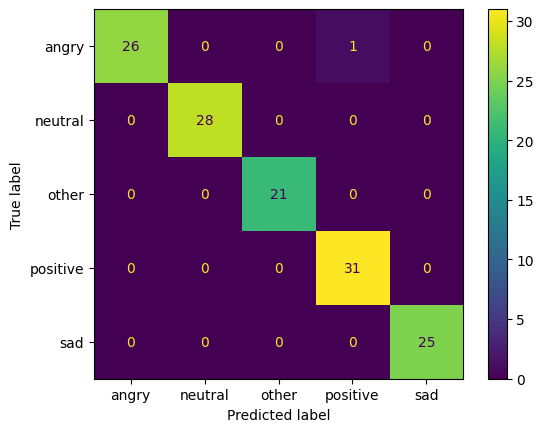

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(gts, preds, labels=list(config.label2id.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(config.label2id.keys()))
disp.plot()

plt.show()

In [16]:
from sklearn.metrics import classification_report

print(classification_report(gts, preds, target_names=list(config.label2id.keys())))

              precision    recall  f1-score   support

       angry       1.00      0.96      0.98        27
     neutral       1.00      1.00      1.00        28
       other       1.00      1.00      1.00        21
    positive       0.97      1.00      0.98        31
         sad       1.00      1.00      1.00        25

    accuracy                           0.99       132
   macro avg       0.99      0.99      0.99       132
weighted avg       0.99      0.99      0.99       132

